In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import glob, os
%matplotlib inline  
plt.rcParams['svg.fonttype'] = 'none'



In [2]:
data = pd.read_csv("S01-S03_dataTable.csv",sep=",", header=0,
           dtype={"template_ID":str,"match":int,"template":str,"strandC":str,"strandR":str,"strandR_len":int,"strandC_len":int,"template_align":str,"strand_align":str,})

# remove the small minority (~0.3%, 5884/1971233 )of unexpectedly long strands for easier processing
data_lenFilt = data.loc[data["strandC_len"]<=16]  
data = data_lenFilt


In [3]:
data.head(5)

,template_ID,match,template,strandC,strandC_len,strandR,strandR_len,template_align,strand_align
0,S01a,0,ACTGATCGTAGCA,CTCTGC,6,CCCTTTTTTCTGGGGGCC,18,ACTGATCGTAGCA,-C---TC-T-GC-
1,S01a,0,ACTGATCGTAGCA,ACTGC,5,AAAAACCCCCTTTGGGGC,18,ACTGATCGTAGCA,----A-C-T-GC-
2,S01a,0,ACTGATCGTAGCA,CTGC,4,CCCCTTTTGGGGC,13,ACTGATCGTAGCA,------C-T-GC-
3,S01a,0,ACTGATCGTAGCA,ACTC,4,AACCCCCTCCCCC,13,ACTGATCGTAGCA,----A-C-T--C-
4,S01a,0,ACTGATCGTAGCA,CTGC,4,CCCCCTGGGGGCC,13,ACTGATCGTAGCA,------C-T-GC-


In [4]:
strands = ['S01a','S01b','S01c','S02a','S02b','S02c','S03a','S03b','S03c']
for currstrand in strands:
    curr_total = data.loc[data["template_ID"]==currstrand].shape[0]
    curr_matches = data.loc[(data["template_ID"]==currstrand) & data["match"]==1].shape[0]
    print(currstrand,curr_total,curr_matches)

S01a 193034 1
S01b 221003 684
S01c 153049 286
S02a 278108 3545
S02b 385879 4889
S02c 176707 248
S03a 185367 464
S03b 169030 273
S03c 209056 898


/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


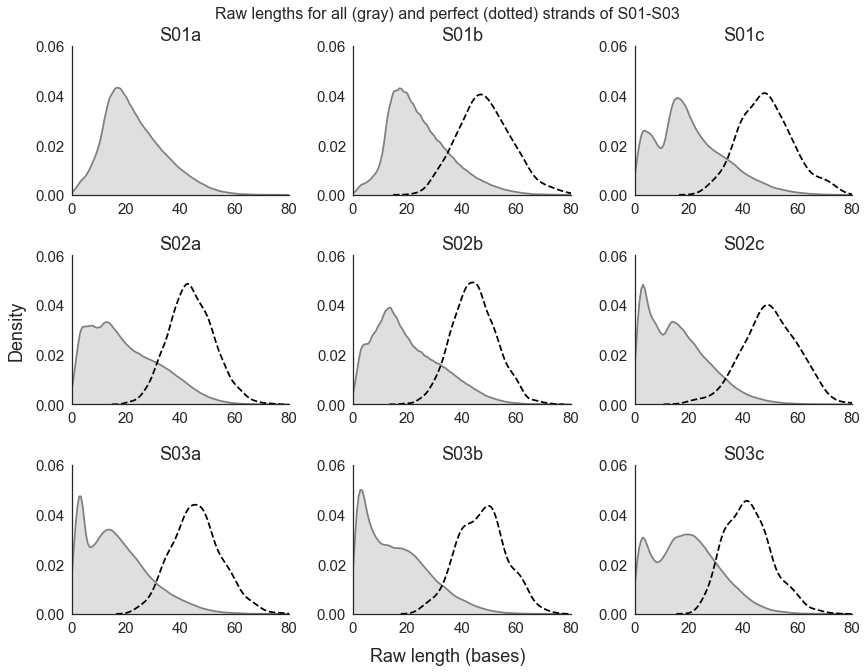

In [5]:
import matplotlib.ticker as plticker
loc = plticker.MultipleLocator(base=0.02) # this locator puts ticks at regular intervals

plt.rcParams['svg.fonttype'] = 'none'
sns.set(font_scale=1.5, style="white")

strands = ['S01a','S01b','S01c','S02a','S02b','S02c','S03a','S03b','S03c']

fig, ax = plt.subplots()
fig.set_size_inches(12, 9) 

plotnum = 1
for i in strands:
    currSample = data.loc[data["template_ID"]==i]
    rawlengths = currSample["strandR_len"].astype("float")
    matches = currSample.loc[currSample["match"]==1, "strandR_len"].astype("float")
    
    plt.subplot(3, 3, plotnum)
    plotnum+=1
    g=sns.kdeplot(rawlengths,shade=True, color="gray")
    g=sns.kdeplot(matches,linestyle="dashed",color="black")

    g.legend_.remove()
    sns.despine()
    g.set(title=i)

    g.set(xlim=(0, 80))
    g.set(ylim=(0, 0.06))

plt.tight_layout()
fig.text(0.5, -0.01, 'Raw length (bases)', ha='center')
fig.text(-0.01, 0.5, 'Density', va='center', rotation='vertical')
fig.suptitle('Raw lengths for all (gray) and perfect (dotted) strands of S01-S03', fontsize=16, y=1)

plt.savefig("S01-S03_rawlengths_All_Perfect.pdf")

In [6]:
def bulkErrors_count(df):

    #to account for 0s
    matches = [0]*(17)
    mismatches = [0]*(17)
    deletions = [0]*(17)
    insertions = [0]*(17)
    
    num_analyzed = 0
    for index, row in df.iterrows():
        currMatches, currMismatches, currDeletions, currInsertions = 0,0,0,0
        template = row['template']
        template_aligned = list(row['template_align'])
        query_aligned = list(row['strand_align'])

        num_analyzed+=1
        for char_template, char_query in zip(template_aligned, query_aligned):
            action = ''  
            if((char_template == char_query) and ((char_query != '-') or (char_template != '-'))): #match
                currMatches+=1
                action = 'match'
            elif((char_template == '-') and (char_query !='-')):   #insertion           
                currInsertions+=1
                action = 'insertion'
            elif((char_template != char_query) and ((char_query != '-') and (char_template != '-'))): #mismatch if not deletion
                currMismatches+=1
                action = 'mismatch'
            elif((char_query == '-') and (char_template != '-')): #deletion in query
                currDeletions+=1
                action = 'deletion'
        matches[currMatches]+=1
        mismatches[currMismatches]+=1
        deletions[currDeletions]+=1
        insertions[currInsertions]+=1

    bulkData = {'matches':matches,'mismatches':mismatches,'deletions':deletions,'insertions':insertions, 'total':num_analyzed}
    return bulkData


In [7]:
S01 = data.loc[(data["template_ID"]=='S01a') | (data["template_ID"]=='S01b') | (data["template_ID"]=='S01c')]
S02 = data.loc[(data["template_ID"]=='S02a') | (data["template_ID"]=='S02b') | (data["template_ID"]=='S02c')]
S03 = data.loc[(data["template_ID"]=='S03a') | (data["template_ID"]=='S03b') | (data["template_ID"]=='S03c')]
print(S01.shape,S02.shape,S03.shape,data.shape)

(567086, 9) (840694, 9) (563453, 9) (1971233, 9)


In [8]:
S01_errors = bulkErrors_count(S01)
S02_errors = bulkErrors_count(S02)
S03_errors = bulkErrors_count(S03)

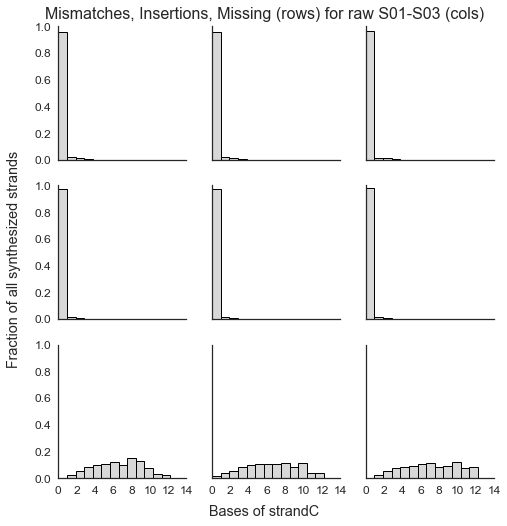

In [9]:
## plot the errors for all strands of S01-S03 
## columns are S01, S02, or S03 
## rows are mismatches, insertions, deletions

import matplotlib.ticker as plticker

plt.rcParams['figure.figsize'] = 8,8
sns.set(font_scale=1.2)
sns.set_style("white")

numBases = list(range(0,17))

errors_to_plot = [S01_errors, S02_errors, S03_errors]

fig, axes = plt.subplots(nrows=3, ncols=len(errors_to_plot), sharex=True, sharey=True, figsize=(7,7))
axes_list = axes.flatten()
i=0

loc = plticker.MultipleLocator(base=2.0) # this locator puts ticks at regular intervals

y=0
for strands in errors_to_plot:
    
    curr_matches = strands['matches']
    curr_matches_normalized = [entry/strands['total'] for entry in curr_matches]

    curr_mismatches = strands['mismatches']
    curr_mismatches_normalized = [entry/strands['total'] for entry in curr_mismatches]

    curr_insertions = strands['insertions']
    curr_insertions_normalized = [entry/strands['total'] for entry in curr_insertions]

    curr_deletions = strands['deletions']
    curr_deletions_normalized = [entry/strands['total'] for entry in curr_deletions]


    axes_list[i].hist(numBases,17, weights = curr_mismatches_normalized,edgecolor='black', linewidth=1,color='#D8D8D8')
    axes_list[i].set_ylim(0,1)
    axes_list[i].set_xlim(0,14)
    axes_list[i].xaxis.set_major_locator(loc)
    sns.despine(ax=axes_list[i])
    

    axes_list[i+1*len(errors_to_plot)].hist(numBases,17, weights = curr_insertions_normalized,edgecolor='black', linewidth=1,color='#D8D8D8')
    axes_list[i+1*len(errors_to_plot)].set_ylim(0,1)
    axes_list[i+1*len(errors_to_plot)].set_xlim(0,14)
    axes_list[i+1*len(errors_to_plot)].xaxis.set_major_locator(loc)
    sns.despine(ax=axes_list[i+1*len(errors_to_plot)])


    axes_list[i+2*len(errors_to_plot)].hist(numBases,17, weights = curr_deletions_normalized,edgecolor='black', linewidth=1,color='#D8D8D8')
    axes_list[i+2*len(errors_to_plot)].set_ylim(0,1)
    axes_list[i+2*len(errors_to_plot)].set_xlim(0,14)
    axes_list[i+2*len(errors_to_plot)].xaxis.set_major_locator(loc)
    sns.despine(ax=axes_list[i+2*len(errors_to_plot)])
    i+=1
    y+=1

fig.text(0.5, -0.01, 'Bases of strandC', ha='center')
fig.text(-0.01, 0.5, 'Fraction of all synthesized strands', va='center', rotation='vertical')
fig.suptitle('Mismatches, Insertions, Missing (rows) for raw S01-S03 (cols)', fontsize=16, y=1)

plt.tight_layout()
plt.savefig("S01-S03_raw_bulkerrors.pdf")

In [10]:
S01_runLen3to4 = S01.loc[(S01["strandR_len"]>=13*3) & (S01["strandR_len"]<=13*4)]
S02_runLen3to4 = S02.loc[(S02["strandR_len"]>=13*3) & (S02["strandR_len"]<=13*4)]
S03_runLen3to4 = S03.loc[(S03["strandR_len"]>=13*3) & (S03["strandR_len"]<=13*4)]


In [11]:
S01_runLen3to4_errors = bulkErrors_count(S01_runLen3to4)
S02_runLen3to4_errors = bulkErrors_count(S02_runLen3to4)
S03_runLen3to4_errors = bulkErrors_count(S03_runLen3to4)

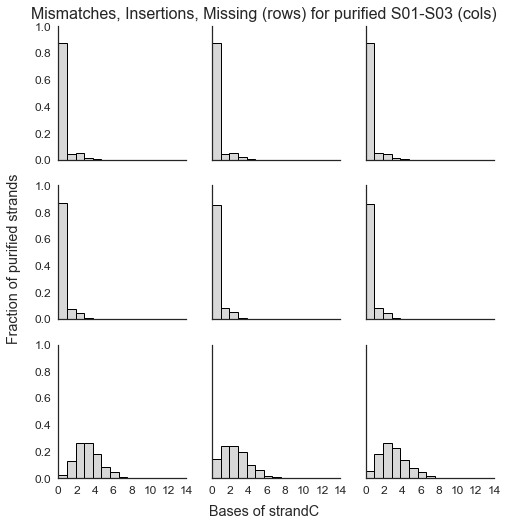

In [12]:
## plot the errors for in silico purified strands of S01-S03, assuming extension of 3-4.  
## columns are S01, S02, or S03 
## rows are mismatches, insertions, deletions

import matplotlib.ticker as plticker

plt.rcParams['figure.figsize'] = 8,8
sns.set(font_scale=1.2)
sns.set_style("white")

numBases = list(range(0,17))

errors_to_plot = [S01_runLen3to4_errors, S02_runLen3to4_errors, S03_runLen3to4_errors]


fig, axes = plt.subplots(nrows=3, ncols=len(errors_to_plot), sharex=True, sharey=True, figsize=(7,7))
axes_list = axes.flatten()
i=0

loc = plticker.MultipleLocator(base=2.0) 

for strands in errors_to_plot:
    
    curr_matches = strands['matches']
    curr_matches_normalized = [entry/strands['total'] for entry in curr_matches]

    curr_mismatches = strands['mismatches']
    curr_mismatches_normalized = [entry/strands['total'] for entry in curr_mismatches]

    curr_insertions = strands['insertions']
    curr_insertions_normalized = [entry/strands['total'] for entry in curr_insertions]

    curr_deletions = strands['deletions']
    curr_deletions_normalized = [entry/strands['total'] for entry in curr_deletions]

    axes_list[i].hist(numBases,17, weights = curr_mismatches_normalized,edgecolor='black', linewidth=1,color='#D8D8D8')
    axes_list[i].set_ylim(0,1)
    axes_list[i].set_xlim(0,17)
    axes_list[i].xaxis.set_major_locator(loc)
    sns.despine(ax=axes_list[i])

    axes_list[i+1*len(errors_to_plot)].hist(numBases,17, weights = curr_insertions_normalized,edgecolor='black', linewidth=1,color='#D8D8D8')
    axes_list[i+1*len(errors_to_plot)].set_ylim(0,1)
    axes_list[i+1*len(errors_to_plot)].set_xlim(0,14)
    axes_list[i+1*len(errors_to_plot)].xaxis.set_major_locator(loc)
    sns.despine(ax=axes_list[i+1*len(errors_to_plot)])


    axes_list[i+2*len(errors_to_plot)].hist(numBases,17, weights = curr_deletions_normalized,edgecolor='black', linewidth=1,color='#D8D8D8')
    axes_list[i+2*len(errors_to_plot)].set_ylim(0,1)
    axes_list[i+2*len(errors_to_plot)].set_xlim(0,14)
    axes_list[i+2*len(errors_to_plot)].xaxis.set_major_locator(loc)
    sns.despine(ax=axes_list[i+2*len(errors_to_plot)])

    i+=1

fig.text(0.5, -0.01, 'Bases of strandC', ha='center')
fig.text(-0.01, 0.5, 'Fraction of purified strands', va='center', rotation='vertical')
fig.suptitle('Mismatches, Insertions, Missing (rows) for purified S01-S03 (cols)', fontsize=16, y=1)
    
plt.tight_layout()
plt.savefig("S01-S03_purified_bulkerrors.pdf")

In [13]:
import editdistance

def getCompressedLen(df):
    numBins = df["strandC_len"].max()+1    
    compressedLens = [0]*int(numBins)
    for _, row in df.iterrows():
        curr_compressedlen = int(row["strandC_len"])
        compressedLens[curr_compressedlen]+=1

    return compressedLens

def calcEditDistances(df):
    temp = df.head(1)
    numEdits = temp["template"].str.len().values[0]
    
    edits_dist = [0]*numEdits
    for _, row in df.iterrows():
        template = row['template']
        query = row['strandC']
        dist = editdistance.eval(template,query)
        edits_dist[dist]+=1

    return edits_dist

In [14]:
def getStats(df, minCount):
    stats = {}
    df_seqs = df["strandC"].value_counts()
    
    #filter for sequences that appear at least minCount times
    df_seqs_gt_uniq = df_seqs[df_seqs>=minCount].index.tolist()
    df_seqs_gt = df[df["strandC"].isin(df_seqs_gt_uniq)]
    
    compressedLens_df_seqs_gt = getCompressedLen(df_seqs_gt)
    
    diverselens_df = [0]*17
    for seq in df_seqs_gt_uniq:
        diverselens_df[len(seq)]+=1

    edits_df = [0]*17
    template = df.iloc[0].template
    for seq in df_seqs_gt_uniq:
        dist = editdistance.eval(template,seq)
        edits_df[dist]+=1
        
    stats = {'lens':compressedLens_df_seqs_gt, 'diversity': diverselens_df, 'edits': edits_df}
    return stats

In [15]:
S01_stats = getStats(S01,3)
S02_stats = getStats(S02,3)
S03_stats = getStats(S03,3)

S01_runLen3to4_errors_stats = getStats(S01_runLen3to4,3)
S02_runLen3to4_errors_stats = getStats(S02_runLen3to4,3)
S03_runLen3to4_errors_stats = getStats(S03_runLen3to4,3)

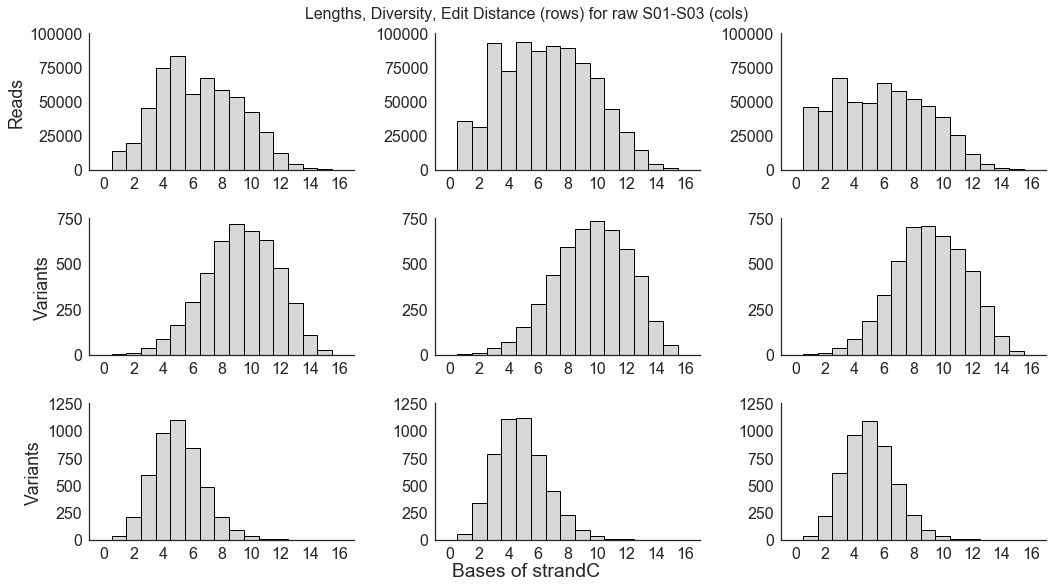

In [16]:
## for all S01-S03 (columns), plot the lengths, diversity, and edit distances (rows)

import matplotlib.ticker as plticker

plt.rcParams['figure.figsize'] = 8,8
sns.set(font_scale=1.6)
plt.rcParams['font.sans-serif'] = 'Myriad Pro'
sns.set_style("white")

fig, axes = plt.subplots(nrows=3, ncols=3, sharex=False, sharey=False, figsize=(15,8))
axes_list = axes.flatten()

xloc = plticker.MultipleLocator(base=2.0) 
yloc = plticker.MultipleLocator(base=250.0) 
yloc2 = plticker.MultipleLocator(base=25000.0) 
yloc3 = plticker.MultipleLocator(base=1000.0) 

to_plot = [S01_stats,S02_stats,S03_stats]

i=0
for strands in to_plot:
    
    numLens = list(range(0,len(strands["lens"])))
    axes_list[i].hist(numLens,bins=np.arange(len(numLens))-0.5, weights = strands["lens"], edgecolor='black', linewidth=1,color='#D8D8D8')
    axes_list[i].xaxis.set_major_locator(xloc)
    axes_list[i].yaxis.set_major_locator(yloc2)
    axes_list[i].set_xlim(-1,17)
    axes_list[i].set_ylim(0,100000)
    if(i==0):
        axes_list[i].set_ylabel('Reads')
    sns.despine(ax=axes_list[i])
        
    numLens = list(range(0,len(strands["diversity"])))
    axes_list[i+1*len(to_plot)].hist(numLens,bins=np.arange(len(numLens))-0.5, weights = strands["diversity"], edgecolor='black', linewidth=1,color='#D8D8D8')
    axes_list[i+1*len(to_plot)].xaxis.set_major_locator(xloc)
    axes_list[i+1*len(to_plot)].yaxis.set_major_locator(yloc)
    axes_list[i+1*len(to_plot)].set_xlim(-1,17)
    axes_list[i+1*len(to_plot)].set_ylim(0,750)
    if(i==0):
        axes_list[i+1*len(to_plot)].set_ylabel('Variants')
    sns.despine(ax=axes_list[i+1*len(to_plot)])

    numEdits = list(range(0,len(strands["edits"])))
    axes_list[i+2*len(to_plot)].hist(numEdits,bins=np.arange(len(numLens))-0.5, weights = strands["edits"], edgecolor='black', linewidth=1,color='#D8D8D8')
    axes_list[i+2*len(to_plot)].xaxis.set_major_locator(xloc)
    axes_list[i+2*len(to_plot)].yaxis.set_major_locator(yloc)
    axes_list[i+2*len(to_plot)].set_xlim(-1,17)
    axes_list[i+2*len(to_plot)].set_ylim(0,1250)
    if(i==0):
        axes_list[i+2*len(to_plot)].set_ylabel('Variants')
    sns.despine(ax=axes_list[i+2*len(to_plot)])
    i+=1

fig.text(0.5, 0.01, 'Bases of strandC', ha='center')
fig.suptitle('Lengths, Diversity, Edit Distance (rows) for raw S01-S03 (cols)', fontsize=16, y=1)

plt.tight_layout()
plt.savefig("S01-S04_raw_Lens_Div_Edits.pdf")


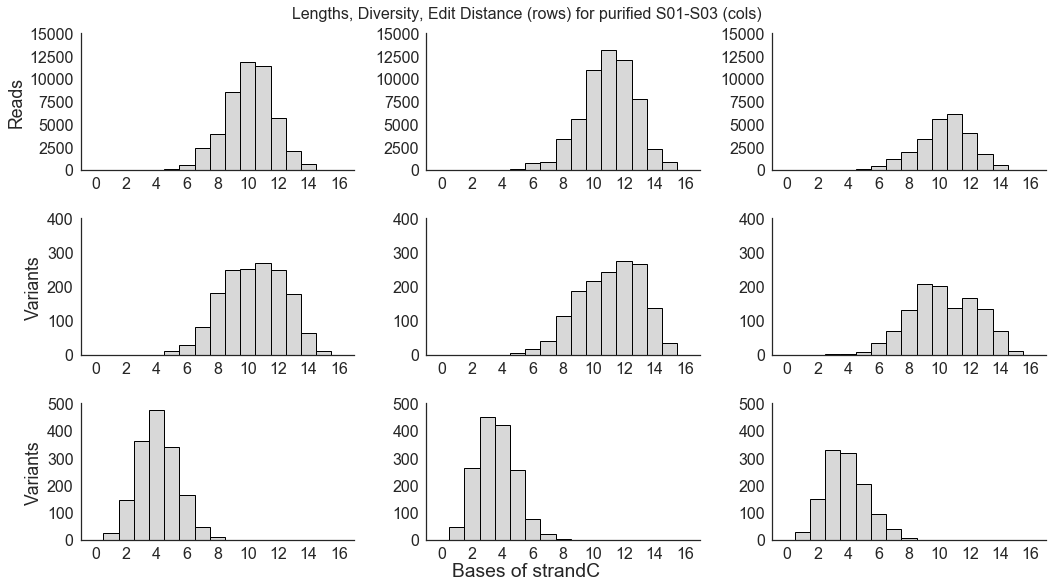

In [17]:
## for all in silico purified S01-S03 based on extension lengths 3-4 (columns),
## plot the lengths, diversity, and edit distances (rows)

import matplotlib.ticker as plticker

plt.rcParams['figure.figsize'] = 8,8
sns.set(font_scale=1.6)
plt.rcParams['font.sans-serif'] = 'Myriad Pro'
sns.set_style("white")

fig, axes = plt.subplots(nrows=3, ncols=3, sharex=False, sharey=False, figsize=(15,8))
axes_list = axes.flatten()

xloc = plticker.MultipleLocator(base=2.0) 
yloc = plticker.MultipleLocator(base=100.0) 
yloc2 = plticker.MultipleLocator(base=2500.0) 

to_plot = [S01_runLen3to4_errors_stats,S02_runLen3to4_errors_stats,S03_runLen3to4_errors_stats]

i=0
for strands in to_plot:
    
    numLens = list(range(0,len(strands["lens"])))
    axes_list[i].hist(numLens,bins=np.arange(len(numLens))-0.5, weights = strands["lens"], edgecolor='black', linewidth=1,color='#D8D8D8')
    axes_list[i].xaxis.set_major_locator(xloc)
    axes_list[i].yaxis.set_major_locator(yloc2)
    axes_list[i].set_xlim(-1,17)
    axes_list[i].set_ylim(0,15000)
    if(i==0):
        axes_list[i].set_ylabel('Reads')

    sns.despine(ax=axes_list[i])


    numLens = list(range(0,len(strands["diversity"])))
    axes_list[i+1*len(to_plot)].hist(numLens,bins=np.arange(len(numLens))-0.5, weights = strands["diversity"], edgecolor='black', linewidth=1,color='#D8D8D8')
    axes_list[i+1*len(to_plot)].xaxis.set_major_locator(xloc)
    axes_list[i+1*len(to_plot)].yaxis.set_major_locator(yloc)
    axes_list[i+1*len(to_plot)].set_xlim(-1,17)
    axes_list[i+1*len(to_plot)].set_ylim(0,400)
    if(i==0):
        axes_list[i+1*len(to_plot)].set_ylabel('Variants')
    sns.despine(ax=axes_list[i+1*len(to_plot)])


    numEdits = list(range(0,len(strands["edits"])))
    axes_list[i+2*len(to_plot)].hist(numEdits,bins=np.arange(len(numLens))-0.5, weights = strands["edits"], edgecolor='black', linewidth=1,color='#D8D8D8')
    axes_list[i+2*len(to_plot)].xaxis.set_major_locator(xloc)
    axes_list[i+2*len(to_plot)].yaxis.set_major_locator(yloc)
    axes_list[i+2*len(to_plot)].set_xlim(-1,17)
    axes_list[i+2*len(to_plot)].set_ylim(0,500)
    if(i==0):
        axes_list[i+2*len(to_plot)].set_ylabel('Variants')    
    sns.despine(ax=axes_list[i+2*len(to_plot)])
    i+=1
plt.tight_layout()
fig.text(0.5, 0.01, 'Bases of strandC', ha='center')
fig.suptitle('Lengths, Diversity, Edit Distance (rows) for purified S01-S03 (cols)', fontsize=16, y=1)
plt.savefig("S01-S04_purified_Lens_Div_Edits.pdf")
